# Watercolor Image Effect
reference: Towards Photo Watercolorization with Artistic Verisimilitude

### Import Libraries

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from noise import pnoise2

#### Some Utils Functions


In [31]:
def plot_without_axis(image, title):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")


def plot_subplots(images, titles, cols=2):
    fig, axes = plt.subplots(1, cols, figsize=(cols * 5, 5))
    if cols == 1:
        axes = [axes]
    for i, (image, title) in enumerate(zip(images, titles)):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        axes[i].imshow(image)
        axes[i].set_title(title)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

### Read Image

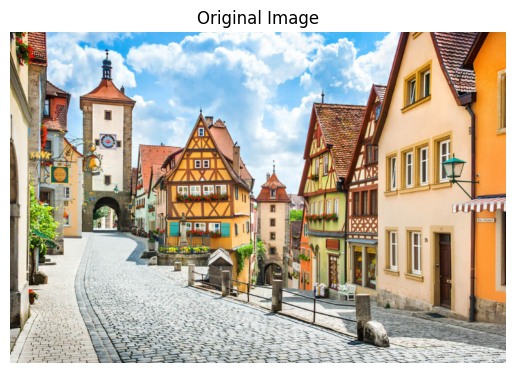

In [32]:
input_dir = "images"
input_filename = "house.jpg"
input_path = f"{input_dir}/{input_filename}"
output_path = f"{input_path.split('.')[0]}_output.jpg"

# load the image
image = cv2.imread(input_path)
resize_factor = image.shape[0] / 512
image = cv2.resize(image, (int(image.shape[1] / resize_factor), int(image.shape[0] / resize_factor)))
plot_without_axis(image, "Original Image")

### Color Adjustment
Change the color of original image to match some specific color style (defined by user in `model.txt`).

In [33]:
def adjust_color(image, model_path="./model/model.txt", style=-1):

    image = image.astype(np.float32) / 255.0
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lab = rgb2lab(image_rgb)
    mean, std = cv2.meanStdDev(image_lab)
    mean = mean.flatten()
    std = std.flatten()

    centers = np.loadtxt(model_path, dtype=np.float32)

    # style -1 means to find the closest style
    if style == -1:
        source_vec = np.concatenate([mean, std])
        dists = np.linalg.norm(centers - source_vec, axis=1)
        best_style = np.argmin(dists)
    else:
        best_style = style

    target_mean = centers[best_style, :3]
    target_std = centers[best_style, 3:]

    # Reinhard color transfer
    image_adj = (image_lab - mean) * (target_std / std) + target_mean
    image_rgb = lab2rgb(image_adj).astype(np.float32)  
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    image_bgr = np.clip(image_bgr * 255, 0, 255).astype(np.uint8)
    return image_bgr

/opt/miniconda3/lib/python3.12/site-packages/skimage/color/colorconv.py:754: RuntimeWarning: divide by zero encountered in matmul
  return arr @ matrix.T.astype(arr.dtype)
/opt/miniconda3/lib/python3.12/site-packages/skimage/color/colorconv.py:754: RuntimeWarning: overflow encountered in matmul
  return arr @ matrix.T.astype(arr.dtype)
/opt/miniconda3/lib/python3.12/site-packages/skimage/color/colorconv.py:754: RuntimeWarning: invalid value encountered in matmul
  return arr @ matrix.T.astype(arr.dtype)


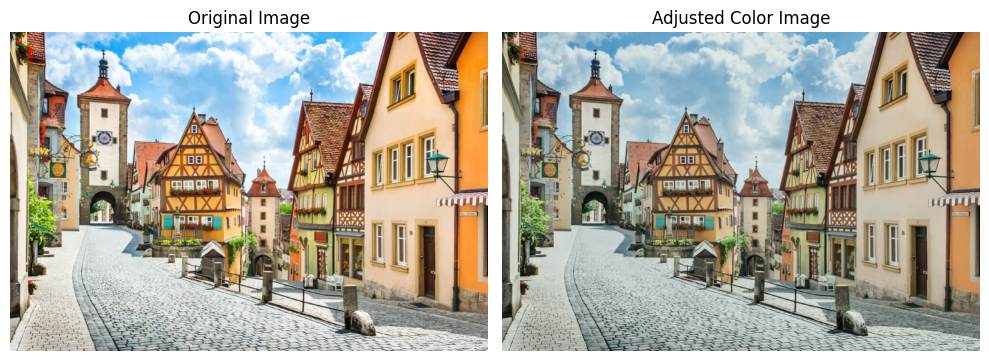

In [34]:
image_adj = adjust_color(image, model_path="./model/model.txt", style=-1)
plot_subplots([image, image_adj], ["Original Image", "Adjusted Color Image"], cols=2)

### Saliency Distance Field
Perform saliency detection to identify the regions that are likely to be emphasized.


In [35]:
def get_binary_saliency_map(image):
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    _, saliencyMap = saliency.computeSaliency(image)
    saliencyMap = cv2.normalize(saliencyMap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    saliencyMap = cv2.GaussianBlur(saliencyMap, (11, 11), 0)
    _, binary = cv2.threshold(saliencyMap, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary


def compute_saliency_distance_field(image):
    # compute saliency map
    binary_saliency = get_binary_saliency_map(image)

    # invert to get the background
    binary_inv = cv2.bitwise_not(binary_saliency)
    dist = cv2.distanceTransform(binary_inv, cv2.DIST_L2, 5)
    norm_dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

    # recursive Gaussian filter to smooth
    for _ in range(10):
        norm_dist = cv2.GaussianBlur(norm_dist, (5, 5), 0)

    return binary_saliency, norm_dist

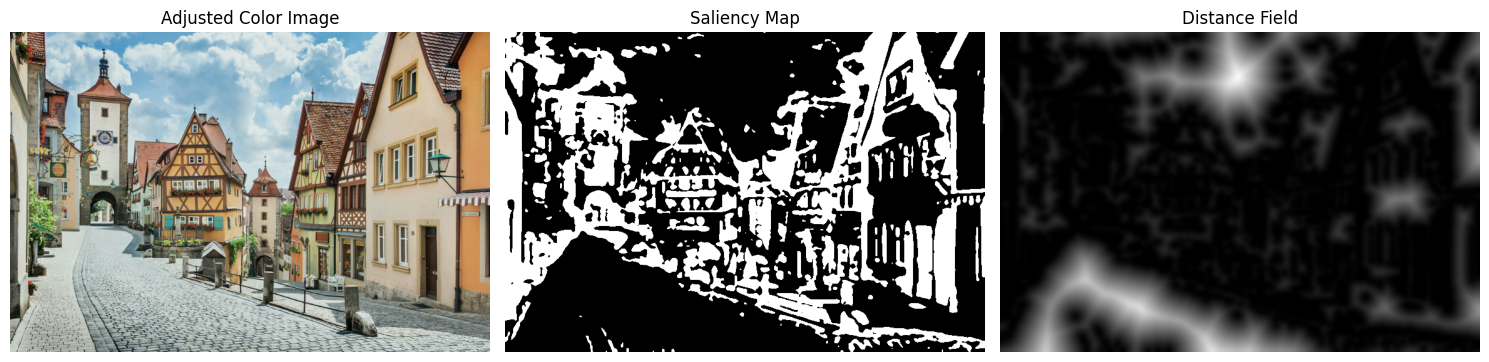

In [36]:
saliency_map, dist_field = compute_saliency_distance_field(image_adj)
plot_subplots([image_adj, saliency_map, dist_field], ["Adjusted Color Image", "Saliency Map", "Distance Field"], cols=3)

### Abstraction
Regions that need not be emphasized will be simplified by abstraction, make variations in salient regions will be better preserved while the surrounding regions will tend to be abstracted.

In [37]:
def abstraction(image_bgr, dist_field, saliency_mask):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).astype(np.uint8)
    image_lab = rgb2lab(image_rgb)
    hfs = cv2.hfs.HfsSegment.create(
        image_rgb.shape[0], image_rgb.shape[1], 0.02, 30, 0.08, 60, 0.3, 32, 16
    )
    segments_rgb = hfs.performSegmentCpu(image_rgb, True)
    segments = cv2.cvtColor(segments_rgb, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    H, W = image_rgb.shape[:2]
    output_lab = image_lab.copy()

    for i in range(H):
        for j in range(W):
            seg_id = segments[i, j]
            d = dist_field[i, j]

            if saliency_mask[i, j]:
                # for salient pixels, use a fixed kernel size of 5
                k = 5
            else:
                # for non-salient pixels, use a larger kernel size clamp(5*2*(d + 0.3), 4, 9)
                k = int(np.clip(5 * 2 * (d + 0.3), 4, 9))
                if k % 2 == 0:
                    k += 1

            half_k = k // 2

            # define local window bounds
            i1 = max(i - half_k, 0)
            i2 = min(i + half_k + 1, H)
            j1 = max(j - half_k, 0)
            j2 = min(j + half_k + 1, W)

            patch_lab = image_lab[i1:i2, j1:j2]
            patch_seg = segments[i1:i2, j1:j2]

            mask = patch_seg == seg_id

            if not saliency_mask[i, j]:
                center_color = image_lab[i, j][np.newaxis, np.newaxis, :]
                diff = np.linalg.norm(patch_lab - center_color, axis=-1)  # (k, k)
                neighbor_mask = (patch_seg != seg_id) & (diff < 0.3 * d)
                mask = mask | neighbor_mask

            if np.any(mask):
                # mean over all qualifying pixels in patch
                output_lab[i, j] = patch_lab[mask].mean(axis=0)

    result_rgb = lab2rgb(output_lab)
    result_bgr = cv2.cvtColor((result_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    return segments, result_bgr

In [38]:
segments.shape

(256, 383)

/opt/miniconda3/lib/python3.12/site-packages/skimage/color/colorconv.py:857: RuntimeWarning: divide by zero encountered in matmul
  return arr @ xyz_from_rgb.T.astype(arr.dtype)
/opt/miniconda3/lib/python3.12/site-packages/skimage/color/colorconv.py:857: RuntimeWarning: overflow encountered in matmul
  return arr @ xyz_from_rgb.T.astype(arr.dtype)
/opt/miniconda3/lib/python3.12/site-packages/skimage/color/colorconv.py:857: RuntimeWarning: invalid value encountered in matmul
  return arr @ xyz_from_rgb.T.astype(arr.dtype)


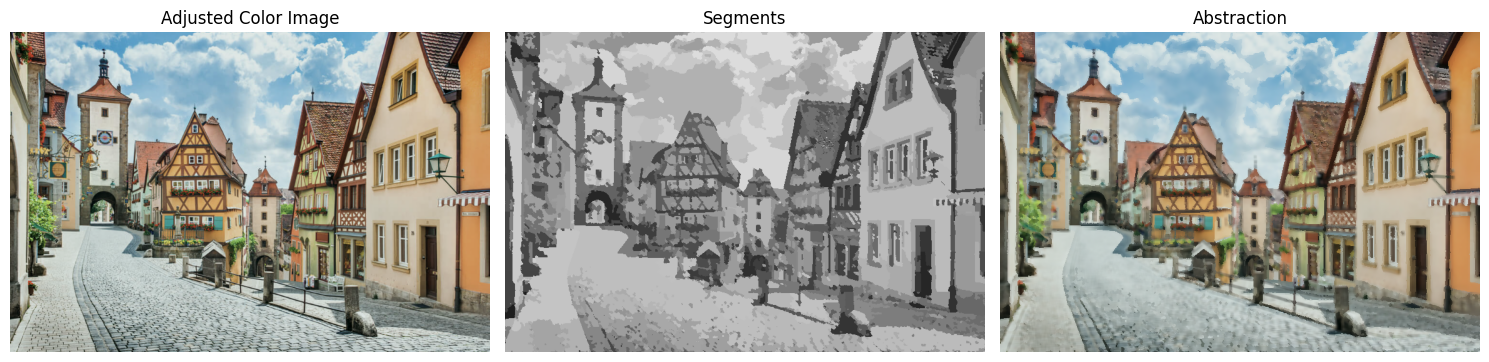

In [39]:
segments, image_abstraction = abstraction(image_adj, dist_field, saliency_map)
plot_subplots([image_adj, segments, image_abstraction], ["Adjusted Color Image", "Segments", "Abstraction"], cols=3)

### Compute Boundaries
Region boundaries are classified into the following three groups with regard to the application of the hand tremor effect.
1. Boundaries in a wet-in-wet area should not be distorted;
2. Boundaries of regions with similar hues are distorted without overlaps and gaps;
3. The other boundaries are distorted with overlaps and gaps, as supposed to be generated by the hand tremor effect.

In [40]:
def angle(a, b):
    return min(abs(int(a) - int(b)), 180 - abs(int(a) - int(b)))


def boundary_classification(image_bgr, saliency_distance_field):
    h, w = image_bgr.shape[:2]
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # compute gradients
    grad_x = cv2.Scharr(image_gray, cv2.CV_16S, 1, 0)
    grad_y = cv2.Scharr(image_gray, cv2.CV_16S, 0, 1)

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    gradient = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    _, boundary = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    result = np.zeros_like(boundary, dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            if boundary[i, j] == 255:
                dx = int(grad_x[i, j])
                dy = int(grad_y[i, j])
                mag = np.hypot(dx, dy)
                if mag < 1e-5:
                    continue
                dx = int(3 * dx / mag)
                dy = int(3 * dy / mag)

                front = (j + dx, i + dy)
                back = (j - dx, i - dy)

                if not (
                    0 <= front[0] < w
                    and 0 <= front[1] < h
                    and 0 <= back[0] < w
                    and 0 <= back[1] < h
                ):
                    continue

                front_h, front_s, front_v = image_hsv[front[1], front[0]]
                back_h, back_s, back_v = image_hsv[back[1], back[0]]
                d = saliency_distance_field[i, j]

                # Boundaries in a wet-in-wet area should not be distorted;
                if (d < 0.3 and angle(front_h, back_h) < 10) or (
                    d >= 0.3 and angle(front_h, back_h) < 45
                ):
                    result[i, j] = 1
                # Boundaries of regions with similar hues are distorted without overlaps and gaps;
                elif (
                    angle(front_h, back_h) < 45
                    or min(front_s, back_s) < 45
                    or min(front_v, back_v) < 45
                ):
                    for a in range(-3, 4):
                        for b in range(-3, 4):
                            y, x = i + a, j + b
                            if 0 <= y < h and 0 <= x < w:
                                if result[y, x] != 1:
                                    result[y, x] = 2
                # The other boundaries are distorted with overlaps and gaps, as supposed to be generated by the hand tremor effect.
                else:
                    for a in range(-3, 4):
                        for b in range(-3, 4):
                            y, x = i + a, j + b
                            if 0 <= y < h and 0 <= x < w:
                                if result[y, x] not in [1, 2]:
                                    result[y, x] = 3
    return result, grad_x, grad_y

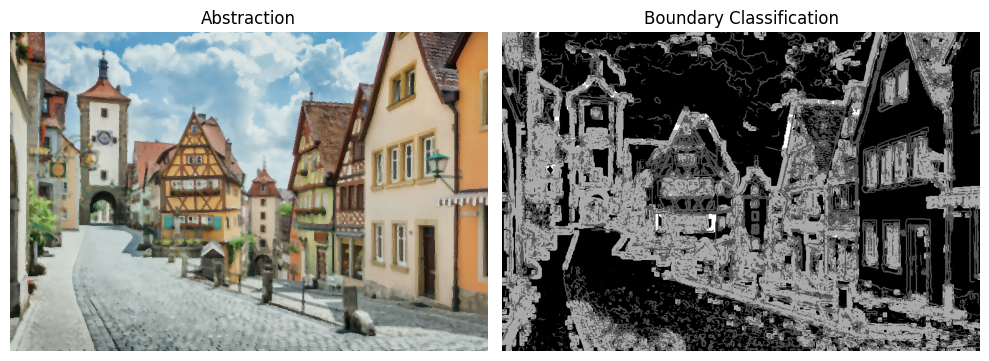

In [41]:
boundary, grad_x, grad_y = boundary_classification(image_abstraction, dist_field)
boundary_vis = cv2.normalize(boundary, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plot_subplots([image_abstraction, boundary_vis], ["Abstraction", "Boundary Classification"], cols=2)

### Hand Tremor Effect
A watercolorist hardly draws straight lines without breaks or wiggling because human muscles can hardly be controlled accurately due to the noise in the human nervous system.

In [ ]:
def get_perlin_noise(height, width, scale=0.1, seed=0):
    noise_image = np.zeros((height, width), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            noise_val = pnoise2(
                x * scale, y * scale, repeatx=width, repeaty=height, base=seed
            )
            noise_image[y, x] = noise_val

    return noise_image

In [ ]:
def hand_tremor(image_bgr, segments, boundary_map, perlin_generator):
    h, w = image_bgr.shape[:2]
    image_bgr = image_bgr.copy()
    output = image_bgr.copy()

    # generate 4 sets of perlin noise for displacement vectors
    def generate_noise_set():
        noise1 = np.zeros((h, w), dtype=np.float32)
        noise2 = np.zeros((h, w), dtype=np.float32)
        noise3 = np.zeros((h, w), dtype=np.float32)
        noise4 = np.zeros((h, w), dtype=np.float32)
        base = 0.7
        div_sum = 0.0

        for _ in range(8):
            full_noise = perlin_generator(h * 2, w * 2, base)
            base /= 2
            noise1 += full_noise[0:h, 0:w] / base
            noise2 += full_noise[h : 2 * h, 0:w] / base
            noise3 += full_noise[0:h, w : 2 * w] / base
            noise4 += full_noise[h : 2 * h, w : 2 * w] / base
            div_sum += 1.0 / base

        for noise in [noise1, noise2, noise3, noise4]:
            noise /= div_sum
            cv2.normalize(
                noise, noise, alpha=-1.35 + 7, beta=2.35 - 7, norm_type=cv2.NORM_MINMAX
            )

        return noise1, noise2, noise3, noise4

    n1, n2, n3, n4 = generate_noise_set()

    for y in range(h):
        for x in range(w):
            b_type = boundary_map[y, x]

            # distorted without overlaps and gaps
            if b_type == 2:
                dx, dy = int(n1[y, x]), int(n2[y, x])
                tx, ty = x + dx, y + dy
                if 0 <= tx < w and 0 <= ty < h:
                    output[y, x] = image_bgr[ty, tx]

            # distorted with overlaps and gaps
            elif b_type == 3:
                dx1, dy1 = int(n1[y, x]), int(n2[y, x])
                dx2, dy2 = int(n3[y, x]), int(n4[y, x])
                tx1, ty1 = x + dx1, y + dy1
                tx2, ty2 = x + dx2, y + dy2

                color1 = image_bgr[y, x].astype(np.float32)
                color2 = image_bgr[y, x].astype(np.float32)

                if 0 <= tx1 < w and 0 <= ty1 < h:
                    if segments[y, x] == segments[ty1, tx1]:
                        color1 = image_bgr[ty1, tx1]

                if 0 <= tx2 < w and 0 <= ty2 < h:
                    if segments[y, x] == segments[ty2, tx2]:
                        color2 = image_bgr[ty2, tx2]

                mix = 0.5 * color1 + 0.5 * color2
                output[y, x] = mix.astype(np.uint8)

    return np.clip(output, 0, 255).astype(np.uint8)

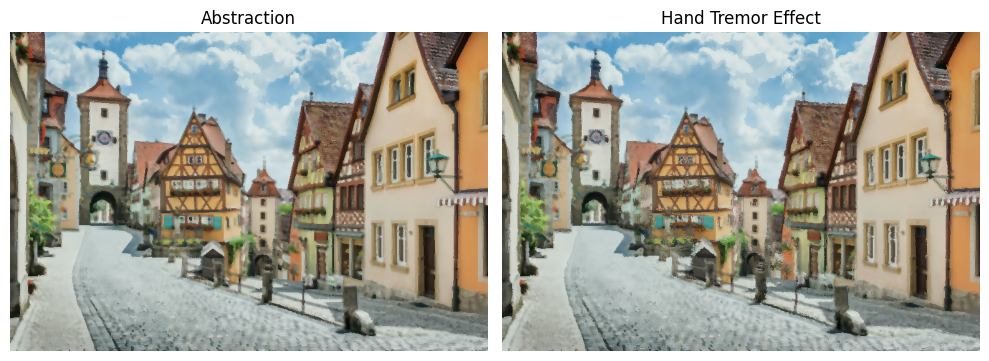

In [44]:
image_hand_tremor = hand_tremor(image_abstraction, segments, boundary, get_perlin_noise)
plot_subplots([image_abstraction, image_hand_tremor], ["Abstraction", "Hand Tremor Effect"], cols=2)